The competition dataset is based on the [2016 NYC Yellow Cab trip record data](https://cloud.google.com/bigquery/public-data) made available in Big Query on Google Cloud Platform. The data was originally published by the [NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

In [1]:
import warnings
import os
import pandas as pd
import numpy as np

from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

warnings.filterwarnings("ignore")

/home/bartosz/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_path = os.path.join('Datasets', 'nyc_taxi', 'train.csv')
test_path = os.path.join('Datasets', 'nyc_taxi', 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])

train_df = train_df.sample(frac=1)

In [3]:
print('Shape (train):', train_df.shape)
print('Shape (test):', test_df.shape)

train_df.head()

Shape (train): (1458644, 11)
Shape (test): (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
763246,id0327848,1,2016-02-19 17:45:59,2016-02-19 17:51:57,1,-73.963890,40.768017,-73.960365,40.774841,N,358
179025,id1020204,1,2016-05-27 14:13:00,2016-05-27 14:27:40,1,-73.981735,40.760391,-73.991875,40.763935,N,880
841350,id0916067,2,2016-01-28 16:37:25,2016-01-28 16:45:33,3,-73.966919,40.794369,-73.976936,40.790119,N,488
362537,id0796267,2,2016-03-26 13:49:30,2016-03-26 13:52:31,1,-73.967865,40.755463,-73.973183,40.748394,N,181
443309,id0721838,1,2016-06-21 08:56:31,2016-06-21 09:00:25,1,-73.976021,40.788143,-73.970764,40.788696,N,234


There are 1 458 644 training rows and 625 134 testing rows. Data is relatively huge. There are 2 less columns in training data - trip duration (target) and dropoff datetime.

Data fields

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

In [4]:
print(train_df.isna().sum())
print(test_df.isna().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


There are no missing values. Let's see the distribution of labels.

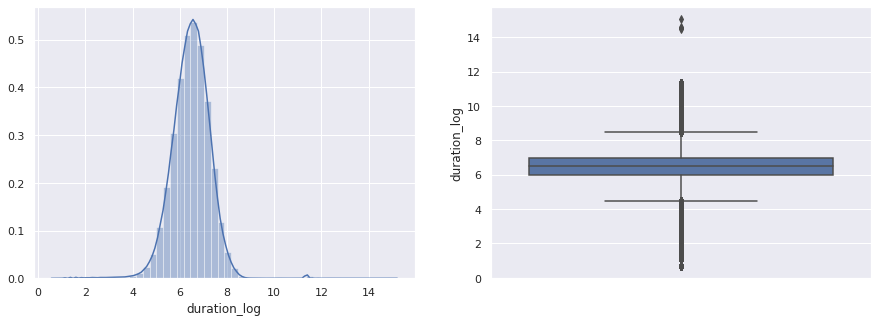

In [5]:
train_df['duration_log'] = np.log1p(train_df['trip_duration'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(train_df['duration_log'], ax=ax1)
sns.boxplot(y='duration_log', data=train_df, ax=ax2)

Evaluation is based on logarithmic RMSE so generally outliers are not a big problem. Despite that I will try to remove especially huge values using interquartile range.

### Removing outliers

The ideo of using interquartile range is really simple. The first thing to do is to calculate the difference between 75 percentile and 25 percentile - it is called interquartile range (IQR). Then I will remove all obserations that are higher than **median + 1.5 * IQR** or low than **median - 1.5 * IQR**.

In [6]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low_b = q1 - 1.5 * iqr
    high_b = q3 + 1.5 * iqr
    mask = ((df[col] >= low_b)
            & (df[col] <= high_b))
    df = df.loc[mask]
    return df

In [7]:
train_df = remove_outliers(train_df, 'duration_log')

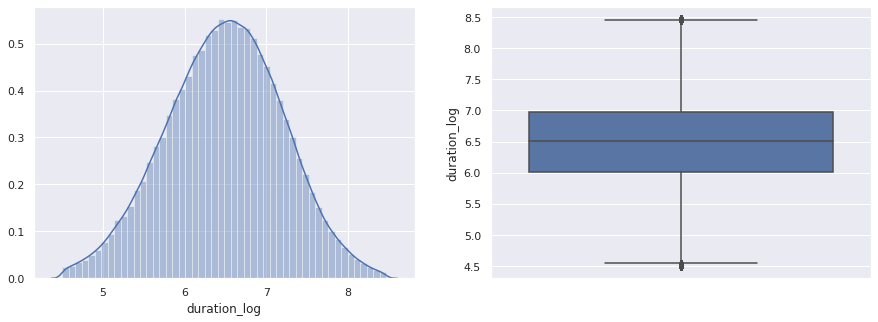

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(train_df['duration_log'], ax=ax1)
sns.boxplot(y='duration_log', data=train_df, ax=ax2)

Now it looks really good. Distribution is approximately normal and there are no outliers. I will remove outliers from geographic coordinates. We have a lot of rows in traing data so i don't think it can be harmful. 

In [9]:
geo_cols = ['pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude']
for col in geo_cols:
    train_df = remove_outliers(train_df, col)

Let's see the map of New York City. I will not use all data because it is too large. Let's just take a part of it

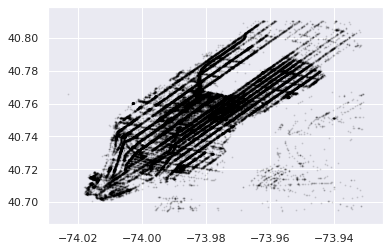

In [10]:
n = train_df.sample(100_000, random_state=42).index

plt.scatter(train_df.loc[n, 'pickup_longitude'], train_df.loc[n, 'pickup_latitude'],
            alpha=0.1, color='black', s=1)

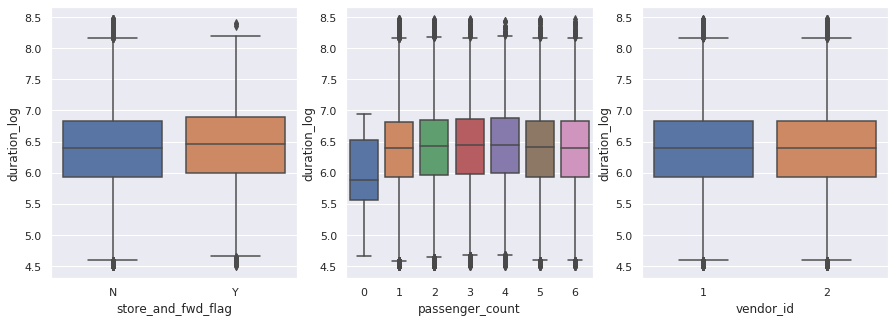

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cols = ['store_and_fwd_flag', 'passenger_count', 'vendor_id']
for col, ax in zip(cols, axes):
    sns.boxplot(x=col, y='duration_log', data=train_df, ax=ax)

It is useful to calculate distances between pickup and dropoff points. There are a lot of different metrics. One of popular distances in geodesy are haversine distance and vincenty's distance. In that notebook I will not use them because I think they are especially useful for calculating huge distances and it is not a case for our dataset. That's why I believe euclidian distance will be enough. Additionally I will use manhattan distance.

In [12]:
def get_euclidian_dist(row):
    long_diff = row['dropoff_longitude'] - row['pickup_longitude']
    lati_diff = row['dropoff_latitude'] - row['pickup_latitude']
    dist = long_diff ** 2 + lati_diff ** 2
    return np.sqrt(dist)

def get_manhatan_dist(row):
    long_diff = row['dropoff_longitude'] - row['pickup_longitude']
    lati_diff = row['dropoff_latitude'] - row['pickup_latitude']
    dist = np.abs(long_diff) + np.abs(lati_diff)
    return dist

train_df['euc_dist'] = train_df.apply(get_euclidian_dist, axis=1)
train_df['man_dist'] = train_df.apply(get_manhatan_dist, axis=1)

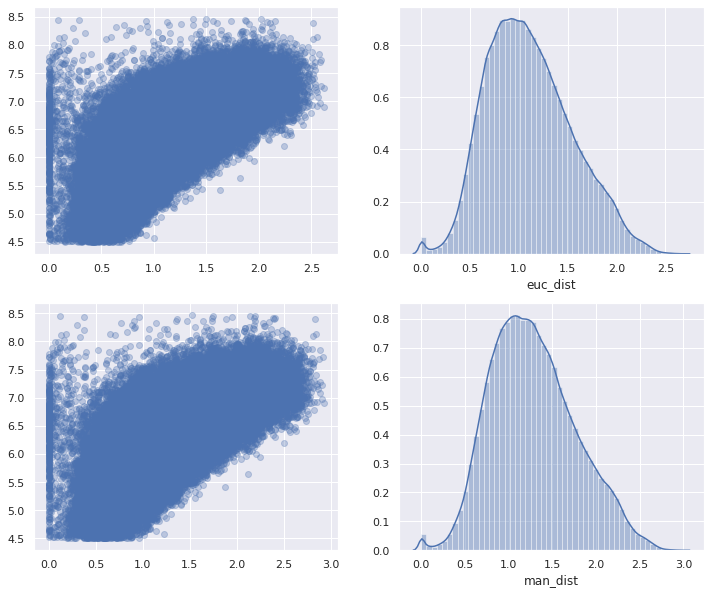

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flat
ax[0].scatter(np.log1p(train_df.loc[n, 'euc_dist'] * 100), 
              train_df.loc[n, 'duration_log'], alpha=0.3)
sns.distplot(np.log1p(train_df['euc_dist'] * 100), ax=ax[1])
ax[2].scatter(np.log1p(train_df.loc[n, 'man_dist'] * 100), 
              train_df.loc[n, 'duration_log'], alpha=0.3)
sns.distplot(np.log1p(train_df['man_dist'] * 100), ax=ax[3])

Well there is a correlation. Additionally it seems that both distances are very correlated and I should choose just one. I think manhattan distance is more reasonable.

### Dates and time

In machine learning algorithms you cannot use just datetimes. They have to be transformed to numbers. We don't need year because it is the same in training and testing data. I will use month, weekday, hour.

In [14]:
train_df['pickup_date'] = train_df['pickup_datetime'].dt.date
train_df['pickup_time'] = train_df['pickup_datetime'].dt.time

train_df['pickup_month'] = train_df['pickup_datetime'].dt.month
train_df['pickup_weekday'] = train_df['pickup_datetime'].dt.weekday
train_df['pickup_hour'] = train_df['pickup_datetime'].dt.hour

test_df['pickup_date'] = test_df['pickup_datetime'].dt.date
test_df['pickup_time'] = test_df['pickup_datetime'].dt.time

test_df['pickup_month'] = test_df['pickup_datetime'].dt.month
test_df['pickup_weekday'] = train_df['pickup_datetime'].dt.weekday
test_df['pickup_hour'] = test_df['pickup_datetime'].dt.hour

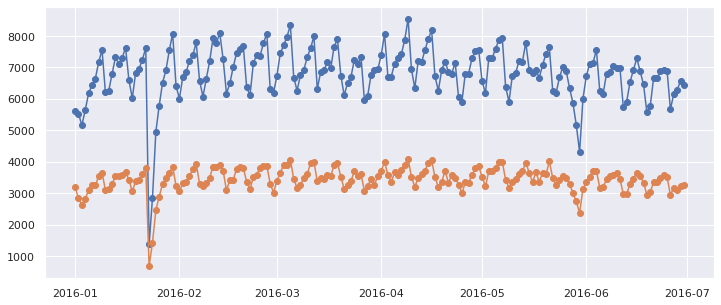

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(train_df.groupby('pickup_date')['id'].count(),
         '-o')
plt.plot(test_df.groupby('pickup_date')['id'].count(),
        '-o')

The idea of predictions is not to predict the future. As you can see training and testing data overlaps. As a result I can use means aggregations and means from training data and use it to enrich testing data. It is not possible if you have to predict the future. A good example is a rolling mean. If you have to predict the future you cannot use rolling mean because well... your task is to predict that. However if time in both datasets overlap rolling mean is known from training data and can be used in testing data.

First let's see duration of trips by hour and weekday.

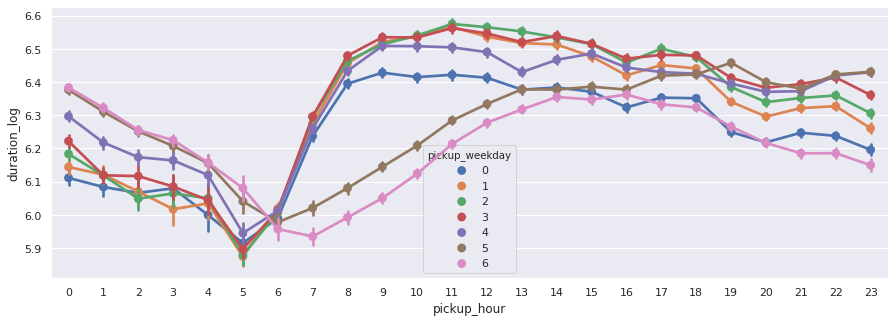

In [16]:
plt.figure(figsize=(15, 5))
sns.pointplot(x='pickup_hour', y='duration_log', 
              hue='pickup_weekday', data=train_df)

The general pattern is similar for every day in a week except Saturday and Sunday. The longest trips are between 8 AM and 6 PM. It seems during night trips are a little shorter. On Saturday and Sunday people travel less and closer.

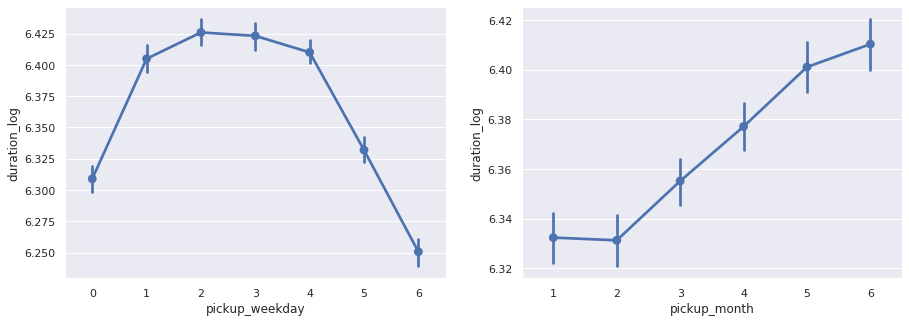

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.pointplot(x="pickup_weekday", y="duration_log", 
              data=train_df.loc[n], ax=axes[0])
sns.pointplot(x='pickup_month', y='duration_log',
              data=train_df.loc[n], ax=axes[1])

Working days are better for taxi drivers - trips are longer. It is reasonable because probably people have to get to the work.

### Speed

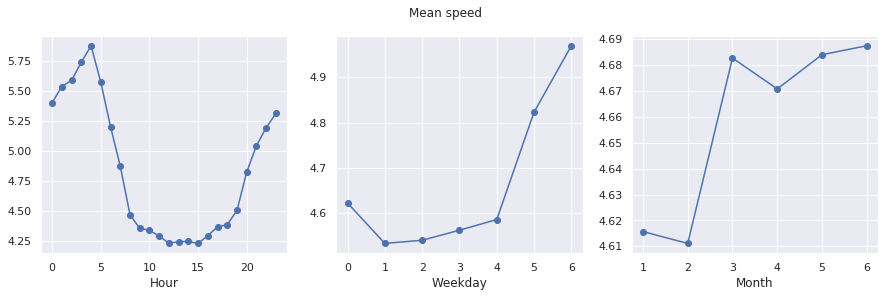

In [18]:
train_df['speed'] = (train_df['man_dist'] * 1000 / train_df['duration_log'])

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(train_df.groupby('pickup_hour')['speed'].mean(), '-o')
ax[0].set_xlabel('Hour')
ax[1].plot(train_df.groupby('pickup_weekday')['speed'].mean(), '-o')
ax[1].set_xlabel('Weekday')
ax[2].plot(train_df.groupby('pickup_month')['speed'].mean(), '-o')
ax[2].set_xlabel('Month')
fig.suptitle('Mean speed');

### New features

I will create new features using speed. First of call let's cluster every observation basing on its geographic coordiantes. Then it is possible to calculate average speed for every district. I will use MiniBatchKMeans. The algorith is really similar to KMeans but a little faster. The idea is simple. it aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. More about MiniBarchKMeans you can find [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)

In [19]:
bin_cols = ['lat_bin', 'long_bin']
train_df[bin_cols] = np.round(train_df[['pickup_latitude', 'pickup_longitude']], 3)
test_df[bin_cols] = np.round(test_df[['pickup_latitude', 'pickup_longitude']], 3)

In [20]:
speed_df = train_df.groupby(bin_cols)['speed'].mean()
speed_df = speed_df.reset_index()
speed_df.rename(columns={'speed': 'mean_speed'}, inplace=True)
count_df = train_df.groupby(bin_cols)['id'].count()
count_df = count_df.reset_index()
speed_df = pd.merge(speed_df, count_df, on=bin_cols)
speed_df = speed_df.loc[speed_df['id'] > 100]
speed_df.drop(columns='id', inplace=True)
speed_df.head()

,lat_bin,long_bin,mean_speed
208,40.701,-74.012,9.600728
234,40.702,-74.013,8.520833
235,40.702,-74.012,9.519039
236,40.702,-74.011,10.148956
266,40.703,-74.014,7.409790


In [21]:
temp = pd.merge(train_df, speed_df, how='left', on=bin_cols)
temp['mean_speed'].isna().sum() / temp['mean_speed'].shape[0]

0.050549528595017844

Only 5% is null values

In [22]:
kmeans= MiniBatchKMeans(n_clusters=15, random_state=42, n_init=10)
districts = np.vstack((train_df[['pickup_longitude', 'pickup_latitude']],
                       train_df[['dropoff_longitude', 'dropoff_latitude']]))
kmeans.fit(districts)
for kind in ['pickup', 'dropoff']:
    cols = [f'{kind}_longitude', f'{kind}_latitude']
    train_df[f'{kind}_cluster'] = kmeans.predict(train_df[cols])

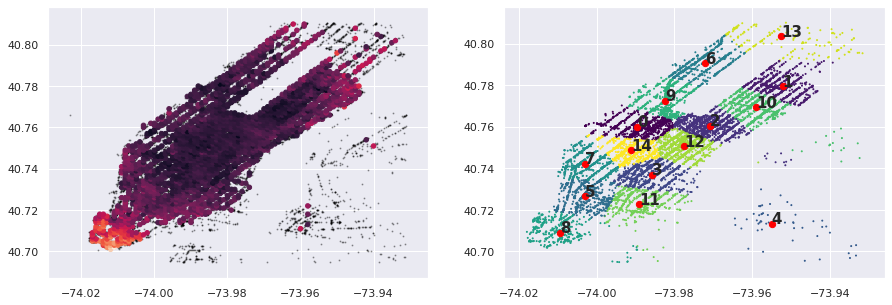

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(train_df.loc[n, 'pickup_longitude'],
              train_df.loc[n, 'pickup_latitude'],
              alpha=0.3, color='black', s=1)
ax[0].scatter(speed_df['long_bin'], speed_df['lat_bin'], 
              c=speed_df['mean_speed'], s=20)

x = train_df.iloc[:10_000]
ax[1].scatter(x['pickup_longitude'], x['pickup_latitude'], 
              c=x['pickup_cluster'], s=1, cmap='viridis')

centers = kmeans.cluster_centers_
lab_cent = zip(np.unique(kmeans.labels_) , centers)
ax[1].scatter(centers[:, 0], centers[:, 1], c='red', s=40)
for label, center in lab_cent:
    ax[1].text(center[0], center[1], str(label), fontsize=15, fontweight='bold')

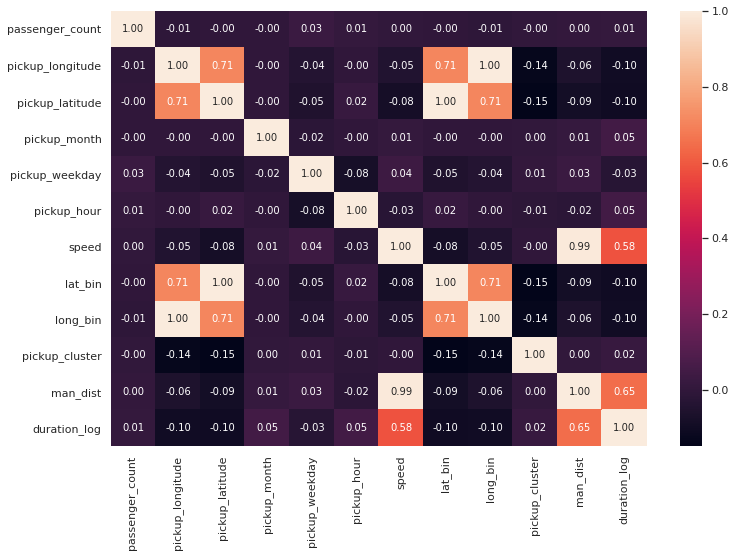

In [24]:
cols_to_corr = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 
                'pickup_month', 'pickup_weekday', 'pickup_hour', 'speed',
                'lat_bin', 'long_bin', 'pickup_cluster', 'man_dist',
                'duration_log']
corr_mat = train_df[cols_to_corr].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat, annot=True, fmt='.2f')

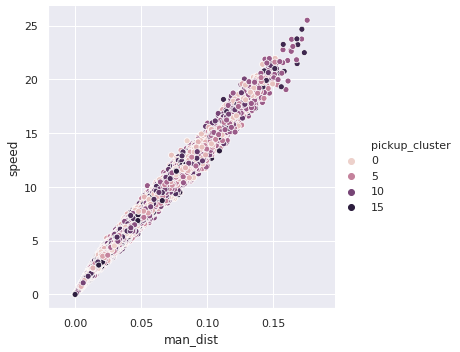

In [25]:
sns.relplot(x='man_dist', y='speed', 
            hue='pickup_cluster', data=train_df.loc[n])

### Preprocessing

In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

In [27]:
cols_to_drop = ['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration',
                'euc_dist', 'pickup_date', 'pickup_time', 'lat_bin', 'long_bin']
train_df.drop(columns=cols_to_drop, inplace=True)
train_df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,duration_log,man_dist,pickup_month,pickup_weekday,pickup_hour,speed,pickup_cluster,dropoff_cluster
763246,1,1,-73.963890,40.768017,-73.960365,40.774841,N,5.883322,0.010349,2,4,17,1.759087,10,10
179025,1,1,-73.981735,40.760391,-73.991875,40.763935,N,6.781058,0.013683,5,4,14,2.017874,0,0
841350,2,3,-73.966919,40.794369,-73.976936,40.790119,N,6.192362,0.014267,1,3,16,2.303962,6,6
362537,2,1,-73.967865,40.755463,-73.973183,40.748394,N,5.204007,0.012386,3,5,13,2.380151,2,12
443309,1,1,-73.976021,40.788143,-73.970764,40.788696,N,5.459586,0.005810,6,1,8,1.064144,6,6


In [28]:
lb = LabelEncoder()
train_df['store_and_fwd_flag'] = lb.fit_transform(train_df['store_and_fwd_flag'])

### Preparing test

In [29]:
set(train_df.columns) - set(test_df.columns)

{'dropoff_cluster', 'duration_log', 'man_dist', 'pickup_cluster', 'speed'}

Adding pickup and dropoff clusters.

In [30]:
for kind in ['pickup', 'dropoff']:
    cols = [f'{kind}_longitude', f'{kind}_latitude']
    test_df[f'{kind}_cluster'] = kmeans.predict(test_df[cols])

Adding speed column

In [31]:
bin_cols = ['lat_bin', 'long_bin']
test_df = pd.merge(test_df, speed_df, on=bin_cols, how='left')
cluster_speed = train_df.groupby('pickup_cluster')['speed'].mean()
cluster_speed = cluster_speed.reset_index()
cluster_speed.rename(columns={'speed': 'cluster_speed'}, inplace=True)
test_df = pd.merge(test_df, cluster_speed, on='pickup_cluster', how='left')
test_df['speed'] = test_df['mean_speed']
test_df.loc[test_df['speed'].isna(), 'speed'] = test_df['cluster_speed']

In [32]:
test_df.drop(columns=['mean_speed', 'cluster_speed'], inplace=True)
test_df['speed'].isna().sum()

0

Adding manhattan distance

In [33]:
test_df['man_dist'] = test_df.apply(get_manhatan_dist, axis=1)
test_df['man_dist'].isna().sum()

0

In [35]:
set(train_df.columns) - set(test_df.columns)

{'duration_log'}

### One hot encoding

In [47]:
category_cols = ['pickup_cluster', 'dropoff_cluster']
train_df[category_cols] = train_df[category_cols].astype('category')
test_df[category_cols] = test_df[category_cols].astype('category')

train_cat = pd.get_dummies(train_df[category_cols])
test_cat = pd.get_dummies(test_df[category_cols])

train_df = pd.concat([train_df, train_cat], axis=1)
test_df = pd.concat([test_df, test_cat], axis=1)

train_df.drop(columns=category_cols, inplace=True)
test_df.drop(columns=category_cols, inplace=True)

In [48]:
X = train_df.drop(columns=['duration_log'])
Y = train_df['duration_log']

scaler = StandardScaler()
X = scaler.fit_transform(X)

### Machine Learning

In [50]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score

In [51]:
model = RidgeCV()
scores = cross_val_score(model, X, Y, scoring='neg_mean_squared_error')
np.sqrt(-np.mean(scores))

0.351757345694951

In [52]:
model = LassoCV()
scores = cross_val_score(model, X, Y, scoring='neg_mean_squared_error')
np.sqrt(-np.mean(scores))

KeyboardInterrupt: 